Model Performance:
MAE: 3.2673
RMSE: 3.5480
R²: -4.5207


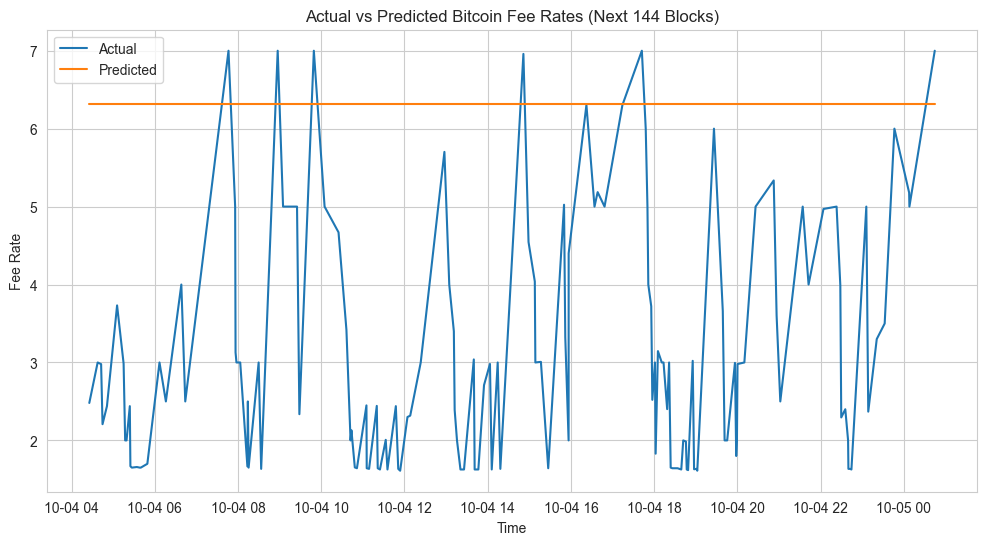


Top 10 Important Features:
                     feature  importance
7              fee_rate_90th    0.521897
17            block_interval    0.127752
29  fee_rate_rolling_mean_10    0.111899
35              fee_rate_roc    0.069732
25            fee_rate_lag_1    0.064268
14         transaction_count    0.043452
30   fee_rate_rolling_std_10    0.027249
12                 total_fee    0.008346
31  fee_rate_rolling_mean_30    0.004913
4               avg_fee_rate    0.004023


<Figure size 1000x600 with 0 Axes>

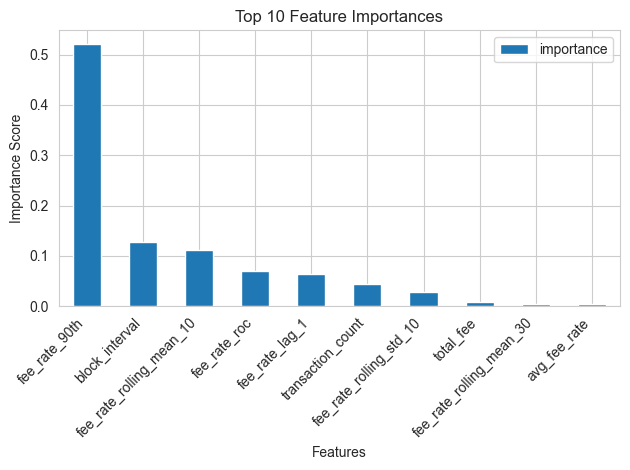

In [6]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv('real_time_cleaned.csv')
df['block_time'] = pd.to_datetime(df['block_time'])
df = df.sort_values('block_time').set_index('block_time')

# Feature engineering
def create_features(df):
    df_feat = df.copy()
    df_feat['hour'] = df_feat.index.hour
    df_feat['day_of_week'] = df_feat.index.dayofweek
    
    for lag in [1, 3, 6, 12]:
        df_feat[f'fee_rate_lag_{lag}'] = df_feat['block_median_fee_rate'].shift(lag)
    
    for window in [10, 30, 60]:
        df_feat[f'fee_rate_rolling_mean_{window}'] = df_feat['block_median_fee_rate'].rolling(window=window).mean()
        df_feat[f'fee_rate_rolling_std_{window}'] = df_feat['block_median_fee_rate'].rolling(window=window).std()
    
    df_feat['fee_rate_roc'] = df_feat['block_median_fee_rate'].pct_change().fillna(0)
    df_feat['mempool_size_roc'] = df_feat['mempool_size_mb'].pct_change().fillna(0)
    
    return df_feat

df = create_features(df)


features = [col for col in df.columns if col not in ['block_median_fee_rate', 'mempool_fee_histogram']]


X = df[features]
y = df['block_median_fee_rate']

# Handle missing values
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())
y = y.loc[X.index]


train_X = X[:-144]
train_y = y[:-144]
test_X = X[-144:]
test_y = y[-144:]

# Scale features
scaler = RobustScaler()
train_X_scaled = pd.DataFrame(scaler.fit_transform(train_X), columns=train_X.columns, index=train_X.index)

# Handle potential NaNs in training data
train_X_scaled = train_X_scaled.replace([np.inf, -np.inf], np.nan).fillna(train_X_scaled.median())
train_y = train_y.loc[train_X_scaled.index].fillna(train_y.median())

# Ensure no NaNs in train_X and train_y
if train_X_scaled.isna().sum().sum() > 0 or train_y.isna().sum() > 0:
    raise ValueError("There are still NaN values in training data.")

# Train XGBoost model
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(train_X_scaled, train_y)

# Function to update features for the next prediction
def update_features(df, new_row, new_prediction):
    df = pd.concat([df, new_row], axis=0)
    df.loc[df.index[-1], 'block_median_fee_rate'] = new_prediction
    df_feat = create_features(df)
    return df_feat.iloc[[-1]]

# Perform rolling forecast
predictions = []
forecast_df = df.iloc[-60:].copy()  # Use last 60 rows for initial context
for i in range(144):
    last_row = forecast_df.iloc[[-1]][features]
    last_row_scaled = pd.DataFrame(scaler.transform(last_row), columns=last_row.columns, index=last_row.index)
    last_row_scaled = last_row_scaled.fillna(last_row_scaled.median())  # Handle potential NaNs
    pred = model.predict(last_row_scaled)[0]
    
    # Add some randomness to the prediction
    volatility = forecast_df['block_median_fee_rate'].std()
    pred = np.random.normal(pred, volatility * 0.1)
    
    if np.isnan(pred):
        pred = forecast_df['block_median_fee_rate'].iloc[-1]  # Fallback to the last known value if NaN
    
    predictions.append(pred)
    
    # Create a new row with updated timestamp
    new_row = forecast_df.iloc[[-1]].copy()
    new_row.index = [new_row.index[0] + pd.Timedelta(minutes=10)]
    
    # Update features
    forecast_df = update_features(forecast_df, new_row, pred)

# Handle potential NaNs in test set
test_X_scaled = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns, index=test_X.index)
test_X_scaled = test_X_scaled.replace([np.inf, -np.inf], np.nan).fillna(test_X_scaled.median())
test_y = test_y.loc[test_X_scaled.index].fillna(test_y.median())

# Ensure no NaNs in test_X and test_y
if test_X_scaled.isna().sum().sum() > 0 or test_y.isna().sum() > 0:
    raise ValueError("There are still NaN values in testing data.")

# Evaluate model
predictions = pd.Series(predictions[:len(test_y)], index=test_y.index)
predictions = predictions.fillna(predictions.median())  # Handle any remaining NaNs in predictions

mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mean_squared_error(test_y, predictions))
r2 = r2_score(test_y, predictions)

print(f"Model Performance:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


plt.figure(figsize=(12, 6))
plt.plot(test_y.index, test_y.values, label='Actual')
plt.plot(test_y.index, predictions, label='Predicted')
plt.title('Actual vs Predicted Bitcoin Fee Rates (Next 144 Blocks)')
plt.xlabel('Time')
plt.ylabel('Fee Rate')
plt.legend()
plt.show()


importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
importance = importance.sort_values('importance', ascending=False)
print("\nTop 10 Important Features:")
print(importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
importance.head(10).plot(kind='bar', x='feature', y='importance')
plt.title('Top 10 Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
